<a href="https://colab.research.google.com/drive/1kPpIAdLSKE6UADlXY71VsX-Hnfz8a1F1?usp=sharing" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NBA Knowledge-base Q&A app
### Using LlamaIndex with Astra Vector Store and Gradio Web Interface

Create a Vector Store with LlamaIndex and CassIO, with NBA data to use as a search engine and text generator, backed by Astra DB. Demonstrate multiple Llama index modules and question answering using the framework, provide observability with Weights and Biases and include a Gradio Web Interface.

Note: much of dataset build code is credited to lifeofbaka (https://github.com/lifeofbaka)

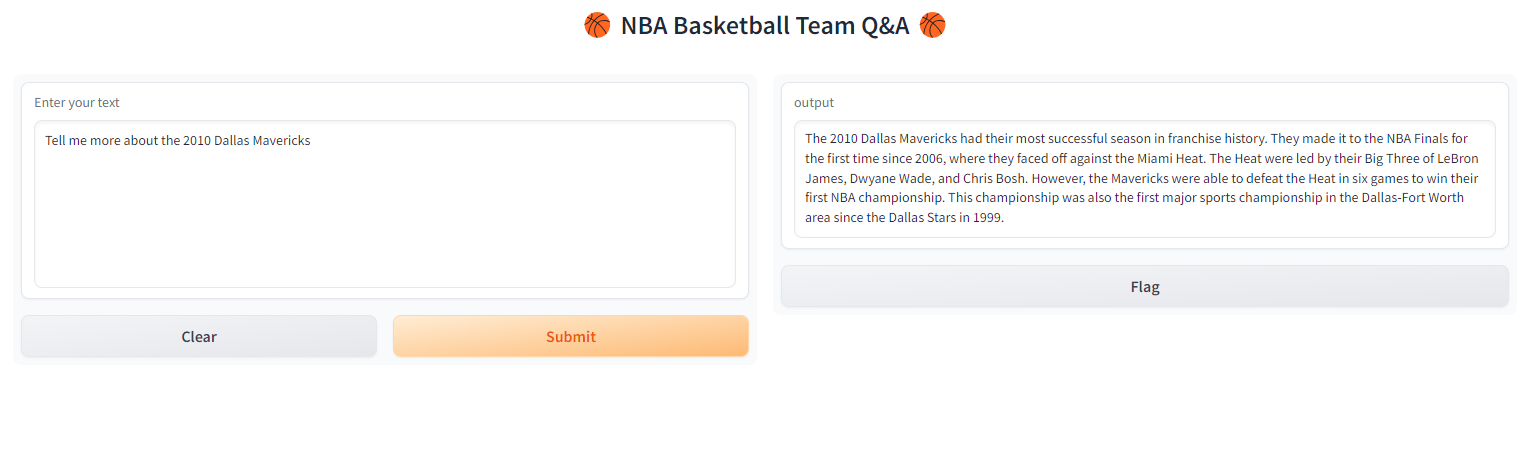

## Colab-specific setup

##Have an Astra Vector Database available and get ready to upload the Secure Connect Bundle and supply the Token string
(see [Pre-requisites](https://cassio.org/start_here/#vector-database) on cassio.org for details. Remember you need a custom Token with role [Database Administrator](https://awesome-astra.github.io/docs/pages/astra/create-token/)).

Likewise, ensure you have the necessary secret for the LLM provider of your choice: you'll be asked to input it shortly
(see [Pre-requisites](https://cassio.org/start_here/#llm-access) on cassio.org for details).

In [1]:
# install required dependencies
! pip install -q --progress-bar off \
    "cassio>=0.1.0" \
    "google-cloud-aiplatform>=1.25.0" \
    "jupyter>=1.0.0" \
    "llama-index" \
    "wandb" \
    "nltk==3.8.1" \
    "pypdf==3.15.2" \
    "python-dotenv==1.0.0" \
    "openai" \
    "langchain" \
    "pypdf" \
    "PyCryptodome" \
    "gradio" \
    "wikipedia" \
    "bs4" \
    "transformers"
exit()

  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
lida 0.0.10 requires kaleido, which is not installed.
llmx 0.0.15a0 requires cohere, which is not installed.
tensorflow-probability 0.22.0 requires typing-extensions<4.6.0, but you have typing-extensions 4.8.0 which is incompatible.


⚠️ **Do not mind a "Your session crashed..." message you may see.**

It was us, making sure your kernel restarts with all the correct dependency versions. _You can now proceed with the notebook._

In [1]:
# imports
from bs4 import BeautifulSoup
import numpy as np
import requests
import re
import pandas as pd
import io
import csv
import wikipedia
from typing import Any, List
import json
import os
import re
from urllib.request import urlopen
import openai
from pathlib import Path
from llama_index import download_loader
from llama_index import (
    GPTVectorStoreIndex,
    GPTSimpleKeywordTableIndex,
    SimpleDirectoryReader,
    LLMPredictor,
    ServiceContext
)
from llama_index import StorageContext, ServiceContext, GPTVectorStoreIndex, LLMPredictor, PromptHelper, SimpleDirectoryReader, load_index_from_storage
from langchain.llms.openai import OpenAIChat
from langchain.chat_models import ChatOpenAI

In [2]:
# Input your database keyspace name:
ASTRA_DB_KEYSPACE = input('Your Astra DB Keyspace name ')

Your Astra DB Keyspace name vector_preview


In [3]:
# Input your Astra DB token string, the one starting with "AstraCS:..."
from getpass import getpass
ASTRA_DB_APPLICATION_TOKEN = getpass('Your Astra DB Token ("AstraCS:..."): ')

Your Astra DB Token ("AstraCS:..."): ··········


### Astra DB Secure Connect Bundle

Please upload the Secure Connect Bundle zipfile to connect to your Astra DB instance.

The Secure Connect Bundle is needed to establish a secure connection to the database.
Click [here](https://awesome-astra.github.io/docs/pages/astra/download-scb/#c-procedure) for instructions on how to download it from Astra DB.

In [4]:
# Upload your Secure Connect Bundle zipfile:
import os
from google.colab import files


print('Please upload your Secure Connect Bundle')
uploaded = files.upload()
if uploaded:
    astraBundleFileTitle = list(uploaded.keys())[0]
    ASTRA_DB_SECURE_BUNDLE_PATH = os.path.join(os.getcwd(), astraBundleFileTitle)
else:
    raise ValueError(
        'Cannot proceed without Secure Connect Bundle. Please re-run the cell.'
    )

Please upload your Secure Connect Bundle


Saving secure-connect-vectordemo.zip to secure-connect-vectordemo.zip


In [5]:
# colab-specific override of helper functions
from cassandra.cluster import (
    Cluster,
)
from cassandra.auth import PlainTextAuthProvider


def getCQLSession(mode='astra_db'):
    if mode == 'astra_db':
        cluster = Cluster(
            cloud={
                "secure_connect_bundle": ASTRA_DB_SECURE_BUNDLE_PATH,
            },
            auth_provider=PlainTextAuthProvider(
                "token",
                ASTRA_DB_APPLICATION_TOKEN,
            ),
        )
        astraSession = cluster.connect()
        return astraSession
    else:
        raise ValueError('Unsupported CQL Session mode')

def getCQLKeyspace(mode='astra_db'):
    if mode == 'astra_db':
        return ASTRA_DB_KEYSPACE
    else:
        raise ValueError('Unsupported CQL Session mode')

### LLM Provider

In the cell below you can choose between **GCP Vertex AI** or **OpenAI** for your LLM services.
(See [Pre-requisites](https://cassio.org/start_here/#llm-access) on cassio.org for more details).

Make sure you set the `llmProvider` variable and supply the corresponding access secrets in the following cell.

In [6]:
# Set your secret(s) for LLM access:
llmProvider = 'OpenAI'  # 'GCP_VertexAI', 'Azure_OpenAI'


In [7]:
from getpass import getpass
if llmProvider == 'OpenAI':
    apiSecret = getpass(f'Your secret for LLM provider "{llmProvider}": ')
    os.environ['OPENAI_API_KEY'] = apiSecret
elif llmProvider == 'GCP_VertexAI':
    # we need a json file
    print(f'Please upload your Service Account JSON for the LLM provider "{llmProvider}":')
    from google.colab import files
    uploaded = files.upload()
    if uploaded:
        vertexAIJsonFileTitle = list(uploaded.keys())[0]
        os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = os.path.join(os.getcwd(), vertexAIJsonFileTitle)
    else:
        raise ValueError(
            'No file uploaded. Please re-run the cell.'
        )
elif llmProvider == 'Azure_OpenAI':
    # a few parameters must be input
    apiSecret = input(f'Your API Key for LLM provider "{llmProvider}": ')
    os.environ['AZURE_OPENAI_API_KEY'] = apiSecret
    apiBase = input('The "Base URL" for your models (e.g. "https://YOUR-RESOURCE-NAME.openai.azure.com"): ')
    os.environ['AZURE_OPENAI_API_BASE'] = apiBase
    apiLLMDepl = input('The name of your LLM Deployment: ')
    os.environ['AZURE_OPENAI_LLM_DEPLOYMENT'] = apiLLMDepl
    apiLLMModel = input('The name of your LLM Model (e.g. "gpt-4"): ')
    os.environ['AZURE_OPENAI_LLM_MODEL'] = apiLLMModel
    apiEmbDepl = input('The name for your Embeddings Deployment: ')
    os.environ['AZURE_OPENAI_EMBEDDINGS_DEPLOYMENT'] = apiEmbDepl
    apiEmbModel = input('The name of your Embedding Model (e.g. "text-embedding-ada-002"): ')
    os.environ['AZURE_OPENAI_EMBEDDINGS_MODEL'] = apiEmbModel

    # The following is probably not going to change for some time...
    os.environ['AZURE_OPENAI_API_VERSION'] = '2023-03-15-preview'
else:
    raise ValueError('Unknown/unsupported LLM Provider')

Your secret for LLM provider "OpenAI": ··········


### Wikipedia Dataset
using help from lifeofbacka to retrieve a dataset from wikipedia. We will focus on NBA teams as the topic of interest. And for demo purposes we'll focus on two teams.

In [8]:
#wiki links
wiki_txt_links = ['https://raw.githubusercontent.com/lifeofbaka/Datasets/main/Wikipedia/wiki' + str(i)+ '.txt' for i in range(1,9)] #if wiki size changes update the range.

In [9]:
# topics

# basketball_teams = [
#     "Atlanta Hawks",
#     "Boston Celtics",
#     "Brooklyn Nets",
#     "Charlotte Hornets",
#     "Chicago Bulls",
#     "Cleveland Cavaliers",
#     "Dallas Mavericks",
#     "Denver Nuggets",
#     "Detroit Pistons",
#     "Golden State Warriors",
#     "Houston Rockets",
#     "Indiana Pacers",
#     "Los Angeles Clippers",
#     "Los Angeles Lakers",
#     "Memphis Grizzlies",
#     "Miami Heat",
#     "Milwaukee Bucks",
#     "Minnesota Timberwolves",
#     "New Orleans Pelicans",
#     "New York Knicks",
#     "Oklahoma City Thunder",
#     "Orlando Magic",
#     "Philadelphia 76ers",
#     "Phoenix Suns",
#     "Portland Trail Blazers",
#     "Sacramento Kings",
#     "San Antonio Spurs",
#     "Toronto Raptors",
#     "Utah Jazz",
#     "Washington Wizards"
# ]
'''

SyntaxError: ignored

In [10]:
# smaller test case with two teams
basketball_teams = [ "Utah Jazz","Dallas Mavericks"]

In [11]:
len(basketball_teams)

2

In [12]:
# Wiki Extraction
# find every wiki that has one of the values in the topic case. Then add values to a list to be read later

nba_wiki = []
for i in range(len(wiki_txt_links)):
   data = urlopen(wiki_txt_links[i]) # it's a file like object and works just like a file
   articles = [line.strip() for line in data] # files are iterable
   for team in basketball_teams:
      for topic in articles:
        if team in str(topic):
          pattern = r'\xe2\x80\x93'
          matches = re.findall(pattern, str(topic))
          if not matches:
            nba_wiki.append(str(topic)[2:-1])
print (len(nba_wiki))

360


In [13]:
nba_wiki

['1978-79 Utah Jazz season',
 '1978\\xe2\\x80\\x9379 Utah Jazz season',
 '1979-80 Utah Jazz',
 '1979-80 Utah Jazz season',
 '1979\\xe2\\x80\\x9380 Utah Jazz',
 '1979\\xe2\\x80\\x9380 Utah Jazz season',
 '1980-81 Utah Jazz',
 '1980-81 Utah Jazz season',
 '1980\\xe2\\x80\\x9381 Utah Jazz',
 '1980\\xe2\\x80\\x9381 Utah Jazz season',
 '1981-82 Utah Jazz',
 '1981-82 Utah Jazz season',
 '1981\\xe2\\x80\\x9382 Utah Jazz',
 '1981\\xe2\\x80\\x9382 Utah Jazz season',
 '1982-83 Utah Jazz',
 '1982-83 Utah Jazz season',
 '1982\\xe2\\x80\\x9383 Utah Jazz',
 '1982\\xe2\\x80\\x9383 Utah Jazz season',
 '1983-84 Utah Jazz',
 '1983-84 Utah Jazz season',
 '1983\\xe2\\x80\\x9384 Utah Jazz',
 '1983\\xe2\\x80\\x9384 Utah Jazz season',
 '1984-85 Utah Jazz',
 '1984-85 Utah Jazz season',
 '1984\\xe2\\x80\\x9385 Utah Jazz',
 '1984\\xe2\\x80\\x9385 Utah Jazz season',
 '1985-86 Utah Jazz',
 '1985-86 Utah Jazz season',
 '1985\\xe2\\x80\\x9386 Utah Jazz',
 '1985\\xe2\\x80\\x9386 Utah Jazz season',
 '1986-87 Utah Jaz

In [14]:
nba_wiki_ = set()
for i in range(len(nba_wiki)):
  try:
    if nba_wiki[i] in nba_wiki[i+1]:
      nba_wiki_.add(nba_wiki[i+1])
    else:
      nba_wiki_.add(nba_wiki(i))
  except:
    nba_wiki_.add(nba_wiki[i])
nba_wiki_ = list(nba_wiki_)
print (len(nba_wiki_))

189


In [15]:
sorted(nba_wiki_)

['1978-79 Utah Jazz season',
 '1978\\xe2\\x80\\x9379 Utah Jazz season',
 '1979-80 Utah Jazz season',
 '1979\\xe2\\x80\\x9380 Utah Jazz season',
 '1980-81 Dallas Mavericks season',
 '1980-81 Utah Jazz season',
 '1980\\xe2\\x80\\x9381 Dallas Mavericks season',
 '1980\\xe2\\x80\\x9381 Utah Jazz season',
 '1981-82 Dallas Mavericks season',
 '1981-82 Utah Jazz season',
 '1981\\xe2\\x80\\x9382 Dallas Mavericks season',
 '1981\\xe2\\x80\\x9382 Utah Jazz season',
 '1982-83 Dallas Mavericks season',
 '1982-83 Utah Jazz season',
 '1982\\xe2\\x80\\x9383 Dallas Mavericks season',
 '1982\\xe2\\x80\\x9383 Utah Jazz season',
 '1983-84 Dallas Mavericks season',
 '1983-84 Utah Jazz season',
 '1983\\xe2\\x80\\x9384 Dallas Mavericks season',
 '1983\\xe2\\x80\\x9384 Utah Jazz season',
 '1984-85 Dallas Mavericks season',
 '1984-85 Utah Jazz season',
 '1984\\xe2\\x80\\x9385 Dallas Mavericks season',
 '1984\\xe2\\x80\\x9385 Utah Jazz season',
 '1985-86 Dallas Mavericks season',
 '1985-86 Utah Jazz season',
 

In [16]:
# remove duplicates
to_remove = ['(football)','(NHL)', '(AFL)', '(hockey)', '(AFL, 1926)', '(American football)', '(WFL)', '(UHL)']
for line in nba_wiki_:
  for item in to_remove:
    if item in line:
      print (line)
      nba_wiki_.remove(line)
print (len(nba_wiki_))


189


In [17]:
#load data function. The function is reliant on a number of table finder functions that have also been assigned below as draft picks and roster.
# The functions find specific table values within the pagent context using Beautiful Soup then output a dictionary from a working dataframe which is then stored within the results dictionary and usable sub topic storage for JSON.

#test
#articles = ['1968–69 Atlanta Hawks season','1968–69_Chicago_Bulls_season']


#WIKIPEDIA PULL
def load_data( pages: List[str], lang: str = "en", **load_kwargs: Any):
    results = []
    for page in pages:
        wikipedia.set_lang(lang)
        try:
          page_content = wikipedia.page(page, **load_kwargs).content
          summary = page_content
          matches = re.findall(r'==\s(.*?)\s==', summary)

          if 'Draft picks' in matches:
              draftpick = draft_picks(page)
          else:
              draftpick = ''
          if 'Roster' in matches:
              team_roster = roster(page)
              pull.append(page)
          else:
              team_roster = ['','']

          data = {page: {"summary": summary, "Draft Pick": draftpick, "Coach": team_roster[0], "Roster": team_roster[1]}}
          results.append(data)
        except:
          pass

    return results

#Tables = re.findall(r"\n== (.*?) ==\n", summary[0])
#print (Tables)


#################################################################################################


def draft_picks(article):
    url = requests.get(f'https://en.wikipedia.org/wiki/{article}').content
    soup = BeautifulSoup(url, 'html.parser')
    tables = []
    for i in soup.find_all('table'):
        tables.append(i)
    for i in range(len(tables)):
        try:
          table_text = tables[i].text
          table_text = table_text.split('\n')

          # find table columns
          col_finder = ' '.join(table_text)
          cols = col_finder.split('   ')
          cols = cols[0].split(' ')

          result_cols = []
          for item in cols:
              if item != '':
                  result_cols.append(item)


          #find table data
          result = []
          pattern = r"(?<=\xa0)\w++"
          for record in table_text:
              match = re.search(r"\xa0(.*)", record)
              if match:
                  result.append(match.group(1))
              else:
                  if record != '':
                      result.append(record)
          result = result[len(result_cols):]
          result = np.array(result)
          shaper = (len(result_cols),int(result.shape[0]/len(result_cols)))

          result = result.reshape(shaper[1],shaper[0])

          df = pd.DataFrame(result, columns=result_cols)
          dictionary = df.to_dict()
          return dictionary
        except:
            pass
    return "could not find table"


def roster(article):
    url = requests.get(f'https://en.wikipedia.org/wiki/{article}').content
    soup = BeautifulSoup(url, 'html.parser')
    tables = []
    for i in soup.find_all('table'):
        tables.append(i)

    for i in range(len(tables)):
        try:
            table_text = tables[i].text
            table_text = table_text.split('\n')

            # find table columns
            col_finder = ' '.join(table_text)
            cols = col_finder.split('   ')
            cols = ' '.join(cols[1:4]).split(' ')

            result_cols = []
            for i in cols:
                if i != '':
                    result_cols.append(i)
            result_cols = result_cols[2:7] + [' '.join(result_cols[7:9])] + result_cols[-1:]


            #find table data
            result = []
            for record in table_text:
                matches = re.findall(r'\xa0', record)
                if matches:
                    result.append(record.replace('\xa0',' '))
                else:
                    if record != '':
                        result.append(record)
            result = result[result.index('From') + 1:result.index('Head coach')]


            #Head Coach


            try:

                shaper = (len(result_cols), int(len(result) / len(result_cols)))
                n_result = np.array(result)
                result = n_result.reshape(shaper[1], shaper[0])

                df = pd.DataFrame(result, columns=result_cols)
                roster_dictionary = df.to_dict()
                coach = {table_text[table_text.index('Head coach'): table_text.index('Head coach') + 1][0]:
                             table_text[table_text.index('Head coach') + 1: table_text.index('Head coach') + 2][0]}

                return coach, roster_dictionary
            except:
                result_cols.remove('DOB (YYYY-MM-DD)')
                result = np.array(result)
                shaper = (len(result_cols), int(result.shape[0] / len(result_cols)))
                result = result.reshape(shaper[1], shaper[0])

                df = pd.DataFrame(result, columns=result_cols)
                new_column = [None for i in range(len(df))]
                position = df.columns.get_loc('Weight') + 1
                df.insert(position, 'DOB (YYYY-MM-DD)', new_column)
                roster_dictionary = df.to_dict()
                coach = {table_text[table_text.index('Head coach'): table_text.index('Head coach') + 1][0]:
                             table_text[table_text.index('Head coach') + 2: table_text.index('Head coach') + 3][0]}

                return coach, roster_dictionary
        except:
            pass
    return "could not find table"

In [18]:
test_i = nba_wiki_.index("2010-11 Dallas Mavericks season")
test_i

187

In [19]:
nba_wiki_[121]

'2017-18 Utah Jazz season'

In [20]:
draft_picks([nba_wiki_[121]])

'could not find table'

### JSON

Call the load function for every value previously extraced and write a JSON file

In [21]:
len(nba_wiki_)

189

In [22]:
pull = []
for value in load_data(pages=sorted(nba_wiki_)):
    for key in value:
      file_name = key.replace("-"," ")
      file_name = file_name.replace(" ","_")
      pull.append(file_name)
      with open(f"{file_name}.json", "w") as file:
        json.dump(value, file, indent=4)

<ipython-input-17-4a317707f5e6>:81: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  dictionary = df.to_dict()
<ipython-input-17-4a317707f5e6>:81: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  dictionary = df.to_dict()
<ipython-input-17-4a317707f5e6>:81: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  dictionary = df.to_dict()
<ipython-input-17-4a317707f5e6>:81: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  dictionary = df.to_dict()
<ipython-input-17-4a317707f5e6>:81: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  dictionary = df.to_dict()
<ipython-input-17-4a317707f5e6>:81: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  dictionary = df.to_dict()
<ipython-input-17-4a317707f5e6>:81: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  dictionary = df.to_dict()
<ipython-inpu

In [23]:
#files in content
sorted(pull)

['1978_79_Utah_Jazz_season',
 '1979-80 Utah Jazz season',
 '1979_80_Utah_Jazz_season',
 '1980-81 Dallas Mavericks season',
 '1980-81 Utah Jazz season',
 '1980_81_Dallas_Mavericks_season',
 '1980_81_Utah_Jazz_season',
 '1981-82 Dallas Mavericks season',
 '1981-82 Utah Jazz season',
 '1981_82_Dallas_Mavericks_season',
 '1981_82_Utah_Jazz_season',
 '1982-83 Dallas Mavericks season',
 '1982-83 Utah Jazz season',
 '1982_83_Dallas_Mavericks_season',
 '1982_83_Utah_Jazz_season',
 '1983-84 Dallas Mavericks season',
 '1983-84 Utah Jazz season',
 '1983_84_Dallas_Mavericks_season',
 '1983_84_Utah_Jazz_season',
 '1984-85 Dallas Mavericks season',
 '1984-85 Utah Jazz season',
 '1984_85_Dallas_Mavericks_season',
 '1984_85_Utah_Jazz_season',
 '1985-86 Dallas Mavericks season',
 '1985-86 Utah Jazz season',
 '1985_86_Dallas_Mavericks_season',
 '1985_86_Utah_Jazz_season',
 '1986-87 Dallas Mavericks season',
 '1986-87 Utah Jazz season',
 '1986_87_Dallas_Mavericks_season',
 '1986_87_Utah_Jazz_season',
 '1

In [24]:
print (len(pull))
print(len(nba_wiki_))

188
189


### Load JSON files into Llama Index

single document test case

In [25]:
print (os.listdir())
print (len(os.listdir()))

['.config', '2001_02_Dallas_Mavericks_season.json', '1979_80_Utah_Jazz_season.json', '1978_79_Utah_Jazz_season.json', '2020_21_Dallas_Mavericks_season.json', '1992_93_Utah_Jazz_season.json', '1983_84_Dallas_Mavericks_season.json', '2004_05_Utah_Jazz_season.json', '1991_92_Dallas_Mavericks_season.json', '1999_2000_Utah_Jazz_season.json', '1997_98_Utah_Jazz_season.json', '2008_09_Utah_Jazz_season.json', '2012_13_Utah_Jazz_season.json', '1981_82_Utah_Jazz_season.json', '1984_85_Dallas_Mavericks_season.json', '1996_97_Dallas_Mavericks_season.json', '1980_81_Dallas_Mavericks_season.json', '2022_23_Utah_Jazz_season.json', '2006_07_Dallas_Mavericks_season.json', '1987_88_Dallas_Mavericks_season.json', '1991_92_Utah_Jazz_season.json', '2000_01_Utah_Jazz_season.json', '2005_06_Dallas_Mavericks_season.json', '1995_96_Dallas_Mavericks_season.json', '2007_08_Dallas_Mavericks_season.json', '1981_82_Dallas_Mavericks_season.json', '1988_89_Utah_Jazz_season.json', '2008_09_Dallas_Mavericks_season.json

In [26]:
p =os.listdir()[1:-1]

In [27]:
file_path = "/content/"

In [28]:
pull_ = set(i for i in pull)
pull

['1979-80 Utah Jazz season',
 '1980-81 Dallas Mavericks season',
 '1980-81 Utah Jazz season',
 '1981-82 Dallas Mavericks season',
 '1981-82 Utah Jazz season',
 '1982-83 Dallas Mavericks season',
 '1982-83 Utah Jazz season',
 '1983-84 Dallas Mavericks season',
 '1983-84 Utah Jazz season',
 '1984-85 Dallas Mavericks season',
 '1984-85 Utah Jazz season',
 '1985-86 Dallas Mavericks season',
 '1985-86 Utah Jazz season',
 '1986-87 Dallas Mavericks season',
 '1986-87 Utah Jazz season',
 '1987-88 Dallas Mavericks season',
 '1987-88 Utah Jazz season',
 '1988-89 Dallas Mavericks season',
 '1988-89 Utah Jazz season',
 '1989-90 Dallas Mavericks season',
 '1989-90 Utah Jazz season',
 '1990-91 Dallas Mavericks season',
 '1990-91 Utah Jazz season',
 '1991-92 Dallas Mavericks season',
 '1991-92 Utah Jazz season',
 '1992-93 Dallas Mavericks season',
 '1992-93 Utah Jazz season',
 '1993-94 Dallas Mavericks season',
 '1993-94 Utah Jazz season',
 '1994-95 Dallas Mavericks season',
 '1994-95 Utah Jazz seaso

In [29]:
paths = []
for i in pull:
  i = i.replace("-", " ")
  i = i.replace(" ",("_"))
  paths.append(file_path +i+".json")

In [30]:
print(paths[0:2])

['/content/1979_80_Utah_Jazz_season.json', '/content/1980_81_Dallas_Mavericks_season.json']


In [31]:
from pathlib import Path
from llama_index import download_loader

JSONReader = download_loader("JSONReader")

loader = JSONReader()


In [32]:
paths[0]

'/content/1979_80_Utah_Jazz_season.json'

In [33]:
document = loader.load_data(Path(paths[34]))

In [34]:
#example of what the fully working JSON file should look like
document

[Document(id_='bd400ae1-6496-4108-a63f-a449c2427f08', embedding=None, metadata={}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={}, hash='92f369d7c0a6ebeac8efc22ce8dabe8073b2cded9f72b048177d2ad90233d70e', text='"1996-97 Utah Jazz season"', start_char_idx=None, end_char_idx=None, text_template='{metadata_str}\n\n{content}', metadata_template='{key}: {value}', metadata_seperator='\n')]

In [35]:
print('Document ID:', document[0].doc_id, 'Document Hash:', document[0].hash)

Document ID: bd400ae1-6496-4108-a63f-a449c2427f08 Document Hash: 92f369d7c0a6ebeac8efc22ce8dabe8073b2cded9f72b048177d2ad90233d70e


### Colab preamble completed

## The following cells constitute the demo notebook proper.

# LlamaIndex, Vector Store

Create a Vector Store with LamaIndex and CassIO, and build a powerful search engine and text generator, backed by Astra DB / Apache Cassandra®.

### Table of contents:

- Setup (database, LLM+embeddings)
- Create Astra vector store
- Insert documents in it
- Test answering questions using a single doc with AStra Vector Search, CassIO and LlamaIndex
- Use Gradio web interface to showcase Q&A across multiple docs
- Cleanup (optional)

_**NOTE:** this uses Cassandra's "Vector Similarity Search" capability.
Make sure you are connecting to a vector-enabled database for this demo._

## Setup

In [36]:
from llama_index import VectorStoreIndex, SimpleDirectoryReader, StorageContext

# for observability
from llama_index.callbacks import CallbackManager, CBEventType
from llama_index.callbacks import LlamaDebugHandler, WandbCallbackHandler
from llama_index import (
    SummaryIndex,
    GPTTreeIndex,
    GPTVectorStoreIndex,
    ServiceContext,
    SimpleDirectoryReader,
    LLMPredictor,
    GPTSimpleKeywordTableIndex,
    StorageContext,
)
from llama_index.indices.composability import ComposableGraph
from llama_index import load_index_from_storage, load_graph_from_storage
#from llama_index.llms import OpenAI



This is the LlamaIndex class providing support for Astra DB / Cassandra:

In [37]:
from llama_index.vector_stores import CassandraVectorStore

A database connection is needed to access Cassandra. The following assumes
that a _vector-search-capable Astra DB instance_ is available. Adjust as needed.

In [38]:
# creation of the DB connection
cqlMode = 'astra_db'
session = getCQLSession(mode=cqlMode)
keyspace = getCQLKeyspace(mode=cqlMode)

ERROR:cassandra.connection:Closing connection <AsyncoreConnection(140037813394480) a4c29bc6-b900-44c5-b980-584a0c4542b5-us-east1.db.astra.datastax.com:29042:f84ce1fc-10d3-4135-accd-60da9b817018> due to protocol error: Error from server: code=000a [Protocol error] message="Beta version of the protocol used (5/v5-beta), but USE_BETA flag is unset"


Both an LLM and an embedding function are required.

Below is the logic to instantiate the LLM and embeddings of choice. We chose to leave it in the notebooks for clarity.

In [39]:
import os
# creation of the LLM resources


if llmProvider == 'OpenAI':
    os.environ['OPENAI_API_TYPE'] = 'open_ai'
    from llama_index.llms import OpenAI
    from llama_index.embeddings import OpenAIEmbedding
    llm = OpenAI(temperature=0)
    myEmbedding = OpenAIEmbedding()
    vector_dimension = 1536
    print("LLM+embeddings from OpenAI")
elif llmProvider == 'GCP_VertexAI':
    from llama_index import LangchainEmbedding
    # LlamaIndex lets you plug any LangChain's LLM+embeddings:
    from langchain.llms import VertexAI
    from langchain.embeddings import VertexAIEmbeddings
    llm = VertexAI()
    lcEmbedding = VertexAIEmbeddings()
    vector_dimension = len(lcEmbedding.embed_query("This is a sample sentence."))
    # ... if you take care of wrapping the LangChain embedding like this:
    myEmbedding = LangchainEmbedding(lcEmbedding)
    print("LLM+embeddings from Vertex AI")
elif llmProvider == 'Azure_OpenAI':
    os.environ['OPENAI_API_TYPE'] = 'azure'
    os.environ['OPENAI_API_VERSION'] = os.environ['AZURE_OPENAI_API_VERSION']
    os.environ['OPENAI_API_BASE'] = os.environ['AZURE_OPENAI_API_BASE']
    os.environ['OPENAI_API_KEY'] = os.environ['AZURE_OPENAI_API_KEY']
    from llama_index import LangchainEmbedding
    # LlamaIndex lets you plug any LangChain's LLM+embeddings:
    from langchain.llms import AzureOpenAI
    from langchain.embeddings import OpenAIEmbeddings
    llm = AzureOpenAI(temperature=0, model_name=os.environ['AZURE_OPENAI_LLM_MODEL'],
                      engine=os.environ['AZURE_OPENAI_LLM_DEPLOYMENT'])
    lcEmbedding = OpenAIEmbeddings(model=os.environ['AZURE_OPENAI_EMBEDDINGS_MODEL'],
                                   deployment=os.environ['AZURE_OPENAI_EMBEDDINGS_DEPLOYMENT'])
    vector_dimension = len(lcEmbedding.embed_query("This is a sample sentence."))
    # ... if you take care of wrapping the LangChain embedding like this:
    myEmbedding = LangchainEmbedding(lcEmbedding)
    print('LLM+embeddings from Azure OpenAI')
else:
    raise ValueError('Unknown LLM provider.')

print(f"Vector dimension for this embedding model: {vector_dimension}")

LLM+embeddings from OpenAI
Vector dimension for this embedding model: 1536


In [40]:
# Observability
# option 1 (errored with "NameError: name 'llama_index' is not defined")
#from llama_index import set_global_handler
#set_global_handler("wandb", run_args={"project": "llamaindex"})
#wandb_callback = llama_index.global_handler
#service_context = ServiceContext.from_defaults(llm=llm)

# Used option
llama_debug = LlamaDebugHandler(print_trace_on_end=True)
# wandb.init args
run_args = dict(
    project="llamaindex",
    )
wandb_callback = WandbCallbackHandler(run_args=run_args)
#callback_manager = CallbackManager([llama_debug, wandb_callback]) #this errored so went with the straight llama_debug below
callback_manager = CallbackManager([llama_debug])
#service_context = ServiceContext.from_defaults(
#    callback_manager=callback_manager, llm=llm
#    )

# After running the above cell, it provides the W&B run page URL. This contains a trace table with all the events tracked using Weights and Biases’ Prompts feature.
# e.g. https://wandb.ai/kasey-parker/llamaindex/runs/2yf6kpm1?workspace=user-kasey-parker

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Streaming LlamaIndex events to W&B at https://wandb.ai/kasey-parker/llamaindex/runs/shh5xr5k
wandb: `WandbCallbackHandler` is currently in beta.
wandb: Please report any issues to https://github.com/wandb/wandb/issues with the tag `llamaindex`.


The following cell ensures that throughout all of LlamaIndex the LLM and embedding function instantiated above will be used:

In [41]:
from llama_index import ServiceContext
from llama_index import set_global_service_context

service_context = ServiceContext.from_defaults(
    callback_manager=callback_manager,
    llm=llm,
    embed_model=myEmbedding,
    chunk_size=256,
)
set_global_service_context(service_context)

[nltk_data] Downloading package punkt to /tmp/llama_index...
[nltk_data]   Unzipping tokenizers/punkt.zip.


## Create vector store

In [42]:
table_name = 'vs_nba_ll_' + llmProvider

In the LlamaIndex abstractions, the `CassandraVectorStore` instance is best wrapped into the creation of a "storage context", which you'll momentarily use to create the index proper:

In [43]:
storage_context = StorageContext.from_defaults(
    vector_store = CassandraVectorStore(
        session=session,
        keyspace=keyspace,
        table=table_name,
        embedding_dimension=vector_dimension,
        insertion_batch_size=15,
    )
)

## Insert documents into Astra

In [44]:
titles = pull

In [45]:
print(titles[0])
print(len(titles))

1979-80 Utah Jazz season
188


In [46]:
from llama_index.storage.storage_context import StorageContext

openai.api_key = apiSecret

#if index_name not in pinecone.list_indexes():
 # pinecone.create_index(name=index_name, dimension=1536, metric="cosine")
  # pinecone.create_index(index_name, dimension=len(embeds[0]))
# connect to index
# index = pinecone.Index(index_name)
# pinecone.create_index(name=index_name, dimension=1536, metric="cosine")

aa_indices = {}
index_summaries = {}

for astra_title, name in zip(titles, paths):
    metadata_filters = {"name": name}
    storage_context = StorageContext.from_defaults(
      vector_store = CassandraVectorStore(
        session=session,
        keyspace=keyspace,
        table=table_name,
        embedding_dimension=vector_dimension,
        insertion_batch_size=15,
      )
    )

    #aa_docs = SimpleDirectoryReader(input_files=[i for i in paths]).load_data()


    #try:
    document = loader.load_data(Path(name))
    aa_indices[name] = GPTVectorStoreIndex.from_documents(document, storage_context=storage_context)
    aa_indices[name].index_struct.index_id = astra_title
    #except:
    #  pass

    index_summaries[name] = f"Wikipedia article about {name}"

# note the wandb trace messages provided by the added observability

**********
Trace: index_construction
    |_node_parsing ->  0.000484 seconds
      |_chunking ->  0.000158 seconds
    |_embedding ->  0.296974 seconds
**********
**********
Trace: index_construction
    |_node_parsing ->  0.00031 seconds
      |_chunking ->  5.7e-05 seconds
    |_embedding ->  0.1372 seconds
**********
**********
Trace: index_construction
    |_node_parsing ->  0.000374 seconds
      |_chunking ->  7.6e-05 seconds
    |_embedding ->  0.161462 seconds
**********
**********
Trace: index_construction
    |_node_parsing ->  0.000317 seconds
      |_chunking ->  5.9e-05 seconds
    |_embedding ->  0.148991 seconds
**********
**********
Trace: index_construction
    |_node_parsing ->  0.000352 seconds
      |_chunking ->  5.5e-05 seconds
    |_embedding ->  0.166517 seconds
**********
**********
Trace: index_construction
    |_node_parsing ->  0.000303 seconds
      |_chunking ->  5.8e-05 seconds
    |_embedding ->  0.143014 seconds
**********
**********
Trace: index_constr

In [49]:
from llama_index.indices.composability.graph import ComposableGraph

graph = ComposableGraph.from_indices(
    GPTSimpleKeywordTableIndex,
    [index for _, index in aa_indices.items()],
    [summary for _, summary in index_summaries.items()],
    max_keywords_per_chunk=50
)

llm_predictor_chatgpt = LLMPredictor(
    #llm=OpenAIChat(temperature=0, model_name="gpt-4")
    llm=OpenAIChat(temperature=0, model_name="gpt-3.5-turbo")
)
service_context = ServiceContext.from_defaults(llm_predictor=llm_predictor_chatgpt)

custom_query_engines = {
    graph.root_id: graph.root_index.as_query_engine(retriever_mode='simple', service_context=service_context)
}

query_engine = graph.as_query_engine(custom_query_engines=custom_query_engines)

query_str = "Tell me more about the Utah Jazz"
response_chatgpt = query_engine.query(query_str)

print(response_chatgpt)
print(response_chatgpt.get_formatted_sources())

**********
Trace: graph_construction
**********
**********
Trace: query
    |_query ->  0.000867 seconds
      |_retrieve ->  0.000796 seconds
**********
Empty Response



[nltk_data] Downloading package stopwords to /tmp/llama_index...
[nltk_data]   Unzipping corpora/stopwords.zip.
/usr/local/lib/python3.10/dist-packages/langchain/llms/openai.py:811: UserWarning: You are trying to use a chat model. This way of initializing it is no longer supported. Instead, please use: `from langchain.chat_models import ChatOpenAI`
  warnings.warn(


## Answer questions

In [50]:
query_str = "Tell me more about the 2010_11_Dallas_Mavericks_season"
response_chatgpt = query_engine.query(query_str)

if not response_chatgpt or not response_chatgpt.get_formatted_sources():
    print("I am sorry, but your query is outside the boundaries of what I was trained on.")
else:
    print(response_chatgpt)
    print(response_chatgpt.get_formatted_sources())

**********
Trace: query
    |_query ->  13.407935 seconds
      |_retrieve ->  0.001255 seconds
      |_query ->  11.05514 seconds
        |_retrieve ->  0.823952 seconds
          |_embedding ->  0.282366 seconds
        |_synthesize ->  10.230946 seconds
          |_templating ->  2.4e-05 seconds
          |_llm ->  10.228523 seconds
      |_synthesize ->  2.351172 seconds
        |_templating ->  2.1e-05 seconds
        |_llm ->  2.349541 seconds
**********
The 2010-11 Dallas Mavericks season was the season in which the Dallas Mavericks competed in the NBA.
> Source (Doc id: 98bd733c-7b77-4458-9e71-5e8eef0234ca): The 2010-11 Dallas Mavericks season refers to the season in which the Dallas Mavericks, a profess...

> Source (Doc id: a640cbb4-f90d-4a87-b555-676f97dd729e): "2010-11 Dallas Mavericks season"

> Source (Doc id: 7c670e27-f3ef-493f-bf13-7049c0a53a49): "2010-11 Dallas Mavericks season"


In [52]:
query_str = "Tell me more about the 2010_11_Dallas_Mavericks_season Roster"
response_chatgpt = query_engine.query(query_str)

if not response_chatgpt or not response_chatgpt.get_formatted_sources():
    print("I am sorry, but your query is outside the boundaries of what I was trained on.")
else:
    print(response_chatgpt)
    print(response_chatgpt.get_formatted_sources())

**********
Trace: query
    |_query ->  7.826443 seconds
      |_retrieve ->  0.00146 seconds
      |_query ->  3.082442 seconds
        |_retrieve ->  0.354558 seconds
          |_embedding ->  0.228376 seconds
        |_synthesize ->  2.72764 seconds
          |_templating ->  1.9e-05 seconds
          |_llm ->  2.72619 seconds
      |_synthesize ->  4.740967 seconds
        |_templating ->  1.9e-05 seconds
        |_llm ->  4.739525 seconds
**********
The 2010-11 Dallas Mavericks season roster was a group of players who represented the team during that particular season. Unfortunately, without prior knowledge or access to specific information, I am unable to provide further details about the roster.
> Source (Doc id: 278ded58-9b11-4d7b-b582-c1532acc7217): The 2010-11 Dallas Mavericks season roster consisted of a group of players who represented the te...

> Source (Doc id: a640cbb4-f90d-4a87-b555-676f97dd729e): "2010-11 Dallas Mavericks season"

> Source (Doc id: 7c670e27-f3ef-493f-

## Llama index multi doc case

In [53]:
import gradio as gr

In [54]:
# Environment, Loader, Query

def create_service_context():

    #constraint parameters
    max_input_size = 4096
    num_outputs = 512
    max_chunk_overlap = .5
    chunk_size_limit = 600

    #allows the user to explicitly set certain constraint parameters
    prompt_helper = PromptHelper(max_input_size, num_outputs, max_chunk_overlap, chunk_size_limit=chunk_size_limit)

    #LLMPredictor is a wrapper class around LangChain's LLMChain that allows easy integration into LlamaIndex
    llm_predictor = LLMPredictor(llm=ChatOpenAI(temperature=0.5, model_name="gpt-3.5-turbo", max_tokens=num_outputs))
    #llm_predictor = LLMPredictor(llm=ChatOpenAI(temperature=0.5, model_name="gpt-4", max_tokens=num_outputs))

    #constructs service_context
    service_context = ServiceContext.from_defaults(llm_predictor=llm_predictor, prompt_helper=prompt_helper)
    return service_context

In [55]:
def data_ingestion_indexing(directory_path):

    #loads data from the specified directory path
    documents = SimpleDirectoryReader(directory_path).load_data()

    #when first building the index
    index = GPTVectorStoreIndex.from_documents(
        documents, service_context=create_service_context()
    )

    #persist index to disk, default "storage" folder
    index.storage_context.persist()

    return index

In [56]:
def data_querying(input_text):

    #rebuild storage context
    storage_context = StorageContext.from_defaults(persist_dir="./storage")

    #loads index from storage
    index = load_index_from_storage(storage_context, service_context=create_service_context())

    #queries the index with the input text
    response = index.as_query_engine().query(input_text)

    return response.response

### Test Q&A across multiple documents using Gradio Web Interface

In [57]:
iface = gr.Interface(fn=data_querying,
                     inputs=gr.components.Textbox(lines=7, label="Enter your text"),
                     outputs="text",
                     title="🏀 NBA Basketball Team Q&A 🏀")

In [58]:
index = data_ingestion_indexing("/content")

**********
Trace: index_construction
    |_node_parsing ->  0.74693 seconds
      |_chunking ->  0.003503 seconds
      |_chunking ->  0.006304 seconds
      |_chunking ->  0.00505 seconds
      |_chunking ->  0.005701 seconds
      |_chunking ->  0.005364 seconds
      |_chunking ->  0.005298 seconds
      |_chunking ->  0.004539 seconds
      |_chunking ->  0.001649 seconds
      |_chunking ->  0.005212 seconds
      |_chunking ->  0.005984 seconds
      |_chunking ->  0.006298 seconds
      |_chunking ->  0.002033 seconds
      |_chunking ->  0.005582 seconds
      |_chunking ->  0.001947 seconds
      |_chunking ->  0.007023 seconds
      |_chunking ->  0.002019 seconds
      |_chunking ->  0.005103 seconds
      |_chunking ->  0.00605 seconds
      |_chunking ->  0.006259 seconds
      |_chunking ->  0.006678 seconds
      |_chunking ->  0.006349 seconds
      |_chunking ->  0.006301 seconds
      |_chunking ->  0.008484 seconds
      |_chunking ->  0.006281 seconds
      |_chunki

In [59]:
iface.launch(share=True)

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://c2f6bed0596598e7d9.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


## (optional) Cleanup

You may want to clean up your database: in that case, simply run the following cell.

_Warning: this will delete the vector store and all that you stored into it!_

In [ ]:
session.execute(f"DROP TABLE IF EXISTS {keyspace}.{table_name};")